In [1]:
import sys
sys.path.append("/glade/work/zhixing/python_scripts/SOM-SEASONAL/User-defined/")
from Synoptic_regimes import *
import wrf


In [3]:
NODE1_NUM = 2; NODE2_NUM = 2 ## Here, we used 2 * 2 structure to construct SOM model

rain, time, lons_wrf, lats_wrf = extract_wrf_rainnc_data(variable = 'precipitation') ## extract the hourly precip from WRF output

w_x = np.load('/glade/work/zhixing/python_scripts/temp_w_x.npy')  ## the x-position for each pattern
w_y = np.load('/glade/work/zhixing/python_scripts/temp_w_y.npy')  ## the y-position for each pattern


# #-- get the index for each node
#-#
dic_cluster, dic_time = Link_processing(NODE1=NODE1_NUM , NODE2 = NODE2_NUM, w_x = w_x, w_y = w_y, time = time)
## dic_cluster: the indexes for each pattern in each category. e.g. {(0,0):[x1,x2,x3,x4,x5]} means the patterns associated with node (0,0)

Link data with cluster	 Finished...



In [5]:
#### Read the 2-D data including mcin, mcape, lcl, lfc, cloud_top_tem, ice_water_path, liquid_water_path, precipitable_water
###--------------------------$$$$$$$$$$$$$$$$$$
ind_node00 = dic_cluster[(0,0)]; ind_node01 = dic_cluster[(0,1)]; ind_node10 = dic_cluster[(1,0)]; ind_node11 = dic_cluster[(1,1)]

vars_list = ['qcloud_path','slw_qcloud_path','qrain_path','slw_qrain_path','qsnow_path','qice_path',\
             'qgraupel_path', 'ice_water_path', 'liquid_water_path','precipitable_water']
vars_dict = {}
for var in vars_list:
    temp_list = []
    for i in range(6):
        varname = var + str(i) + ".npy"
        var_array = np.load("/glade/work/zhixing/Analysis_DATA/SNOWIE_seasonal_Data/Post-processing_data/" + varname)
        temp_list.append(var_array)
        
    vars_dict[var] = temp_list

vstack_vars_dic_00 = {}; vstack_vars_dic_01 = {}; vstack_vars_dic_10 = {}; vstack_vars_dic_11 = {}
for keys, values in vars_dict.items():
    temp = np.vstack((values[0], values[1], values[2], values[3], values[4], values[5]))
    vstack_vars_dic_00[keys] = np.nanmean(temp[ind_node00], axis=0); vstack_vars_dic_01[keys] = np.nanmean(temp[ind_node01], axis=0); 
    vstack_vars_dic_10[keys] = np.nanmean(temp[ind_node10], axis=0); vstack_vars_dic_11[keys] = np.nanmean(temp[ind_node11], axis=0);
    
## vstack_vars_dic, keys represent the name of variables, values represent the cross-section data for all the timesteps.
###----------------------------------$$$$$$$$$$$$$$
## supercooled liquid water path = qcloud (Temperature < 0) + qrain (Temperature < 0)
vstack_vars_dic_00['slw_path'] = vstack_vars_dic_00['slw_qcloud_path'] + vstack_vars_dic_00['slw_qrain_path'];  
vstack_vars_dic_01['slw_path'] = vstack_vars_dic_01['slw_qcloud_path'] + vstack_vars_dic_01['slw_qrain_path'];
vstack_vars_dic_10['slw_path'] = vstack_vars_dic_10['slw_qcloud_path'] + vstack_vars_dic_10['slw_qrain_path'];
vstack_vars_dic_11['slw_path'] = vstack_vars_dic_11['slw_qcloud_path'] + vstack_vars_dic_11['slw_qrain_path'];

## the composite precipitation maps; the averages on the time dimension
vstack_vars_dic_00['rain'] = np.nanmean(rain[ind_node00], axis = 0)
vstack_vars_dic_01['rain'] = np.nanmean(rain[ind_node01], axis = 0)
vstack_vars_dic_10['rain'] = np.nanmean(rain[ind_node10], axis = 0)
vstack_vars_dic_11['rain'] = np.nanmean(rain[ind_node11], axis = 0)

In [7]:
#====================Get the data====================
#============================================================
wrffile  = Dataset("/glade/work/zhixing/wrfout_d02_2017-01-01_00:00:00")
terrain  = getvar(wrffile, 'ter', timeidx=ALL_TIMES, method = "cat")
lon_wrf  = getvar(wrffile, "XLONG")
lat_wrf  = getvar(wrffile, "XLAT")
#====================Get map projection====================
#============================================================
mapcrs  = get_cartopy(terrain)
# mapcrs  = ccrs.LambertConformal(central_longitude=-115.5, central_latitude=44,standard_parallels=(40, 48))
datacrs = ccrs.PlateCarree()

## prepare for the ploting
vstack_vars_dic_matrix = np.array([[vstack_vars_dic_00, vstack_vars_dic_01], [vstack_vars_dic_10, vstack_vars_dic_11]])

NODE: (0, 0) Maximum IWP: 0.2123534 Minimum IWP: 0.03352696 Mean IWP: 0.08919009
NODE: (0, 1) Maximum IWP: 0.777599 Minimum IWP: 0.04052895 Mean IWP: 0.2683625
NODE: (1, 0) Maximum IWP: 0.19444588 Minimum IWP: 0.022056548 Mean IWP: 0.0692972
NODE: (1, 1) Maximum IWP: 0.42160353 Minimum IWP: 0.03565251 Mean IWP: 0.14963306
CPU times: user 21 s, sys: 126 ms, total: 21.1 s
Wall time: 21.2 s


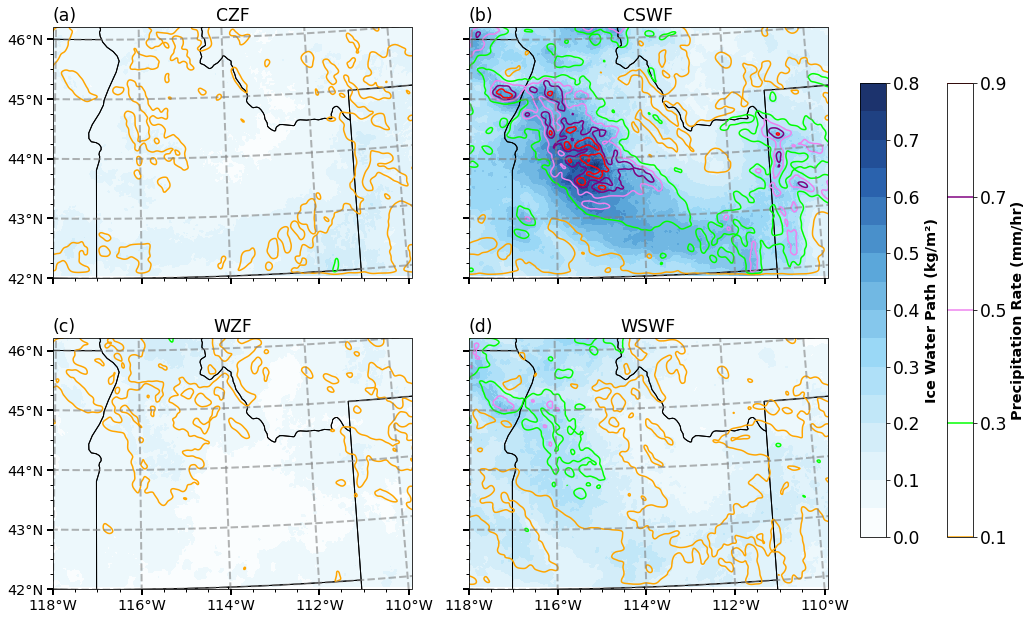

In [8]:
%%time
#************* overlapping these hydrometeors **************

variable_names = ['ice_water_path', 'slw_path']
cbar_labels = ['iwp', 'slw']

plot_lvls_list = [np.linspace(0,0.7,11), np.linspace(0,0.4,11)]
#====================Plot====================
    
fig, axs = plt.subplots(2,2, figsize=(12,9), sharex = True, sharey = True, subplot_kw = {'projection':mapcrs})

for i in range(2):
    for j in range(2):

        ax = axs[i, j]

        # map_extent = [-117, -112, 43, 46]
        map_extent = [-118, -109.9, 42, 46]
        ax.set_extent(map_extent, crs = datacrs)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeature.STATES.with_scale('50m'))

        # ##--- ground precipitation distribution plot

        ice_water_path_data = vstack_vars_dic_matrix[i, j]['ice_water_path']
        slw_path_data       = vstack_vars_dic_matrix[i, j]['slw_path']
        ground_rain_data    = vstack_vars_dic_matrix[i, j]['rain']
        
        print("NODE:",(i,j),"Maximum IWP:", np.nanmax(ice_water_path_data), "Minimum IWP:", np.nanmin(ice_water_path_data), "Mean IWP:", np.nanmean(ice_water_path_data))

        for k in range(10):
            #*** smooth the raw data and then overplap
            ground_rain_data     = wrf.smooth2d(ground_rain_data, passes = 5)  ## try to smooth data and then plot

        shaded_map = ax.contourf(lon_wrf, lat_wrf, ice_water_path_data, cmap = cmaps.WhiteBlue, transform = datacrs, levels=np.arange(0,0.85,0.05))
        color_list = ['orange', 'lime',  'violet', 'purple','red'] ## the color list for 
        contour_line_map = ax.contour(lon_wrf, lat_wrf, ground_rain_data, transform = datacrs, levels=np.arange(0.1,1.1,0.2), colors = color_list)

        # *must* call draw in order to get the axis boundary used to add ticks:
        fig.canvas.draw()
        xticks = list(np.arange(-118,-109,2)); yticks = list(np.arange(42,48,1))

        ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',lw=2,color='gray',alpha=0.6)# dimgrey
        # Label the end-points of the gridlines using the custom tick makers:
        ax.yaxis.set_major_formatter(LATITUDE_FORMATTER); ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
        ax.tick_params(axis='both',length=6,width=2,labelsize='x-large')
        ax.tick_params(axis='both',which='minor',length=3,width=1,labelsize='x-large')
        lambert_yticks(ax, yticks); lambert_xticks(ax, xticks)
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        
##-- title
axs[0,0].set_title("(a)", loc='left', fontsize='xx-large'); axs[0,1].set_title("(b)", loc='left', fontsize='xx-large')
axs[1,0].set_title("(c)", loc='left', fontsize='xx-large'); axs[1,1].set_title("(d)", loc='left', fontsize='xx-large')
axs[0,0].set_title('CZF', fontsize='xx-large'); axs[0,1].set_title('CSWF', fontsize='xx-large');
axs[1,0].set_title('WZF', fontsize='xx-large'); axs[1,1].set_title('WSWF', fontsize='xx-large')

##----- colorbar
cax  = plt.axes([1, 0.15, 0.03, 0.7])
cbar = fig.colorbar(shaded_map, cax = cax)
cbar.ax.tick_params(labelsize='xx-large') 
cbar.set_label(label = 'Ice Water Path (kg/m\u00b2)', weight='bold', fontsize='x-large')

##-----------------
cax  = plt.axes([1.1, 0.15, 0.03, 0.7])
cbar = fig.colorbar(contour_line_map, cax = cax)
cbar.ax.tick_params(labelsize='xx-large') 
cbar.set_label(label = 'Precipitation Rate (mm/hr)', weight='bold', fontsize='x-large')
fig.tight_layout()

NODE: (0, 0) Maximum ratio: 0.54984015 Minimum ratio: 0.002599999 Mean ratio: 0.13898808
NODE: (0, 0) Maximum SLW: 0.11668362 Minimum SLW: 0.0002137566 Mean SLW: 0.0143380035

NODE: (0, 1) Maximum ratio: 0.6639764 Minimum ratio: 0.0030463093 Mean ratio: 0.13418107
NODE: (0, 1) Maximum SLW: 0.4049466 Minimum SLW: 0.00015393482 Mean SLW: 0.044637676

NODE: (1, 0) Maximum ratio: 0.7191656 Minimum ratio: 0.01741143 Mean ratio: 0.24444932
NODE: (1, 0) Maximum SLW: 0.15860616 Minimum SLW: 0.000844391 Mean SLW: 0.023932511

NODE: (1, 1) Maximum ratio: 0.63738227 Minimum ratio: 0.008892026 Mean ratio: 0.16953261
NODE: (1, 1) Maximum SLW: 0.26550433 Minimum SLW: 0.000764425 Mean SLW: 0.03123946



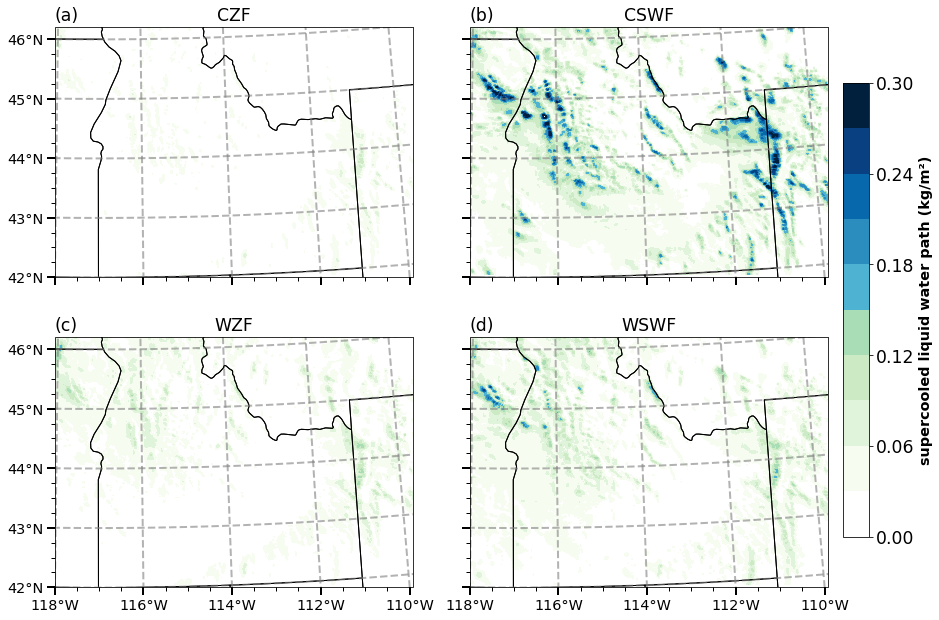

In [9]:
fig, axs = plt.subplots(2,2, figsize=(12,9), sharex=True, sharey=True, subplot_kw = {'projection':mapcrs})

for i in range(2):
    for j in range(2):
        
        ax = axs[i, j]
        map_extent = [-118, -109.9, 42, 46]
        ax.set_extent(map_extent, crs = datacrs)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeature.STATES.with_scale('50m'))
                
        # ##--- ground precipitation distribution plot

        slw_data = vstack_vars_dic_matrix[i, j]['slw_path']
        ice_water_path_data = vstack_vars_dic_matrix[i, j]['ice_water_path']
        ratio_data = (slw_data) / (slw_data + ice_water_path_data)
        print("NODE:",(i,j),"Maximum ratio:", np.nanmax(ratio_data), "Minimum ratio:", np.nanmin(ratio_data), "Mean ratio:", np.nanmean(ratio_data))

        
        for k in range(20):
            #*** smooth the raw data and then overplap
            ratio_data     = wrf.smooth2d(ratio_data, passes = 10)  ## try to smooth data and then plot

        ## cmocean_deep
        plot_2d_data_map = ax.contourf(lon_wrf, lat_wrf, slw_data, cmap = cmaps.CBR_wet, transform = datacrs, levels=np.linspace(0,0.3,11))

        print("NODE:",(i,j),"Maximum SLW:", np.nanmax(slw_data), "Minimum SLW:", np.nanmin(slw_data), "Mean SLW:", np.nanmean(slw_data))
        print("")
        color_list = ['orange','brown', 'red', 'blueviolet', 'purple']
        # color_list = ['orange','darkviolet','deeppink','brown', 'dimgray', 'k']
        # contour_line_map = ax.contour(lon_wrf, lat_wrf, ratio_data, \
        #                               colors = color_list, transform = datacrs, levels=np.arange(0.1,0.51,0.1))

        # *must* call draw in order to get the axis boundary used to add ticks:
        fig.canvas.draw()
        xticks = list(np.arange(-118,-108,2)); yticks = list(np.arange(42,47,1))

        ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',lw=2,color='gray',alpha=0.6)# dimgrey
        # Label the end-points of the gridlines using the custom tick makers:
        ax.yaxis.set_major_formatter(LATITUDE_FORMATTER); ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
        lambert_yticks(ax, yticks); lambert_xticks(ax, xticks)
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.tick_params(axis='both',length=8,width=2,labelsize='x-large')
        ax.tick_params(axis='both',which='minor',length=4,width=1,labelsize='x-large')

axs[0,0].set_title("(a)", loc='left', fontsize='xx-large'); axs[0,1].set_title("(b)", loc='left', fontsize='xx-large')
axs[1,0].set_title("(c)", loc='left', fontsize='xx-large'); axs[1,1].set_title("(d)", loc='left', fontsize='xx-large')

axs[0,0].set_title('CZF', fontsize='xx-large'); axs[0,1].set_title('CSWF', fontsize='xx-large');
axs[1,0].set_title('WZF', fontsize='xx-large'); axs[1,1].set_title('WSWF', fontsize='xx-large')

##-----------------
cax  = plt.axes([0.98, 0.15, 0.03, 0.7])
cbar = fig.colorbar(plot_2d_data_map, cax = cax)
cbar.ax.tick_params(labelsize='xx-large') 
cbar.set_label(label = 'supercooled liquid water path (kg/m\u00b2)', weight='bold', fontsize='x-large')
fig.tight_layout()


NODE: (0, 0) Maximum SLW: 0.11668362 Minimum SLW: 0.0002137566 Mean SLW: 0.0143380035
NODE: (0, 1) Maximum SLW: 0.4049466 Minimum SLW: 0.00015393482 Mean SLW: 0.044637676
NODE: (1, 0) Maximum SLW: 0.15860616 Minimum SLW: 0.000844391 Mean SLW: 0.023932511
NODE: (1, 1) Maximum SLW: 0.26550433 Minimum SLW: 0.000764425 Mean SLW: 0.03123946


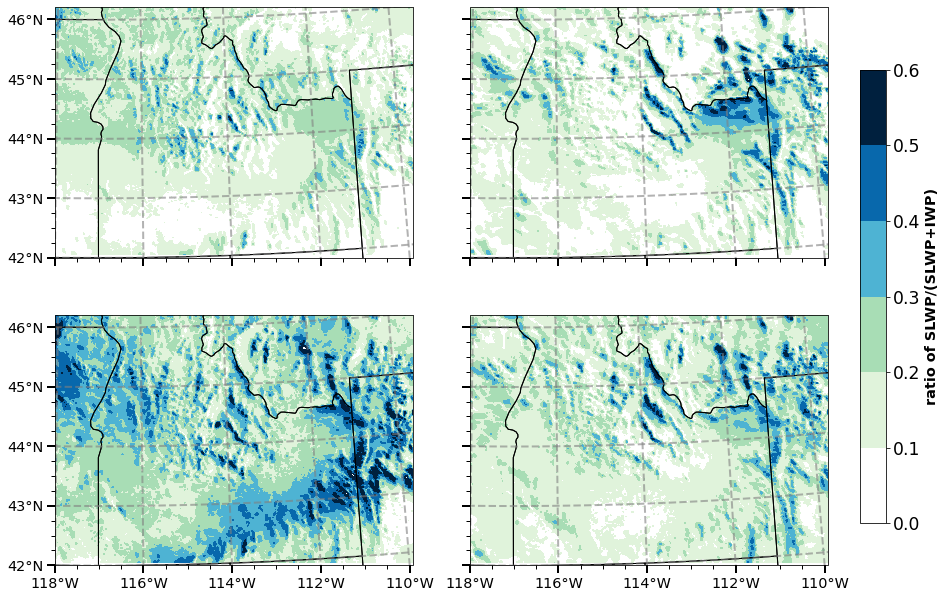

In [10]:
fig, axs = plt.subplots(2,2, figsize=(12,9), sharex=True, sharey=True, subplot_kw = {'projection':mapcrs})

for i in range(2):
    for j in range(2):
        
        ax = axs[i, j]
        map_extent = [-118, -109.9, 42, 46]
        ax.set_extent(map_extent, crs = datacrs)
        ax.add_feature(cfeature.COASTLINE.with_scale('50m'))
        ax.add_feature(cfeature.STATES.with_scale('50m'))
                
        # ##--- ground precipitation distribution plot

        slw_data = vstack_vars_dic_matrix[i, j]['slw_path']
        ice_water_path_data = vstack_vars_dic_matrix[i, j]['ice_water_path']
        ratio_data = (slw_data) / (slw_data + ice_water_path_data)
        
        print("NODE:",(i,j),"Maximum SLW:", np.nanmax(slw_data), "Minimum SLW:",\
              np.nanmin(slw_data), "Mean SLW:", np.nanmean(slw_data))

        # contour_line_map = ax.contour(lon_wrf, lat_wrf, ratio_data, colors = ['darkviolet','orange','deeppink','tomato','red'], transform = datacrs, levels=np.arange(0.1,0.8,0.1))
        contour_line_map = ax.contourf(lon_wrf, lat_wrf, ratio_data,\
                                       cmap=cmaps.CBR_wet, transform = datacrs, levels=np.arange(0,0.601,0.1))

        # *must* call draw in order to get the axis boundary used to add ticks:
        fig.canvas.draw()
        xticks = list(np.arange(-118,-108,2)); yticks = list(np.arange(42,47,1))

        ax.gridlines(xlocs=xticks, ylocs=yticks,linestyle='--',lw=2,color='gray',alpha=0.6)# dimgrey
        # Label the end-points of the gridlines using the custom tick makers:
        ax.yaxis.set_major_formatter(LATITUDE_FORMATTER); ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER) 
        lambert_yticks(ax, yticks); lambert_xticks(ax, xticks)
        ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
        ax.tick_params(axis='both',length=8,width=2,labelsize='x-large')
        ax.tick_params(axis='both',which='minor',length=4,width=1,labelsize='x-large')

# ##-----------------
cax  = plt.axes([1., 0.15, 0.03, 0.7])
cbar = fig.colorbar(contour_line_map, cax = cax)
cbar.ax.tick_params(labelsize='xx-large') 
cbar.set_label(label = 'ratio of SLWP/(SLWP+IWP)', weight='bold', fontsize='x-large')
fig.tight_layout()